## dask usage example
A minimal introduction to using dask (on levante or mistral).

Dask also brings along its own version of numpy with a lazy backend. The following will create an array with the given specifications (random float between 0 and 1 in a 10 by 10 grid). But no random data is created until it is requested specifically.

In [1]:
import dask.array as da

edge_length = 100
x = da.random.random((edge_length,edge_length))
x

dask.array<random_sample, shape=(100, 100), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

We import dask and its SLURM interface, the `Client` and `LocalCluster` classes.

In [2]:
import dask
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, LocalCluster, comm

# Change config to connect to dask dashboard
# this is necessary if running on jupyterhub.dkrz.de. Without it dask will create a local url, 
# not reachable from your browser (but over the dask extension)
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


We also want to make a plot later

In [3]:
import matplotlib.pyplot as plt

If we want to launch a local cluster, no further input is needed, although it is possible to make further specifications. Dask will make assumptions to use the available resources, confined by the slurm job on which your jupyter is running. A dashboard link is provided in the `client` object, which allows to monitor your client over the browser. Also the dask extension should connect automatically.

The extension is hidden behind this dask symbol on the left:

![](https://dask.org/_images/favicon.ico)

In [4]:
client = Client()
client

distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300872/dask-worker-space/worker-iq9mavaq', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300872/dask-worker-space/worker-pmzp74fg', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300872/dask-worker-space/worker-8b_j_q7e', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300872/dask-worker-space/worker-xsq9blgi', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/m300872/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/m300872/levante-spawner-preset//proxy/8787/status,Workers: 4
Total threads: 12,Total memory: 20.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41905,Workers: 4
Dashboard: /user/m300872/levante-spawner-preset//proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 20.00 GiB
Comm: tcp://127.0.0.1:46559,Total threads: 3
Dashboard: /user/m300872/levante-spawner-preset//proxy/36187/status,Memory: 5.00 GiB
Nanny: tcp://127.0.0.1:41161,


The following cell triggers the calculations. This example is not computationally heavy. If you want to test your reesources, be creative.

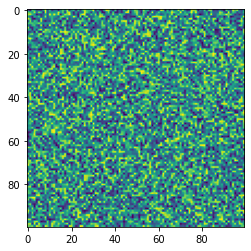

In [5]:
plt.imshow(x)

If you want to use more resources you will have to ask for them via the slurm queue. 

In [6]:
cluster = SLURMCluster(
    project="mh0926", # the project number will have to be connected to your user account. this one wont work
    cores=8, # you can ask for more, you will have to pay them (your project)
    interface='ib0', # to us inifinyband 
    walltime='01:00:00', # reserved time
    extra=["--lifetime", "50m", "--lifetime-stagger", "4m"],  # When using cluster.adapt() this limits the 
    # actual cluster lifetime and allows a 4m overlap for dask to start a new job, once you run into the walltime limit
    queue='compute', # the partition you are requesting. this is necessary.
    memory="120GB"
    )
client = Client(cluster)
client

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44431 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /user/m300872/levante-spawner-preset//proxy/44431/status,
Dashboard: /user/m300872/levante-spawner-preset//proxy/44431/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://136.172.120.115:34697,Workers: 0
Dashboard: /user/m300872/levante-spawner-preset//proxy/44431/status,Total threads: 0
Started: Just now,Total memory: 0 B


This cluster client has to be given resources, either manually (be sure to turn it down again). If you don't scale up, nothing will happen.

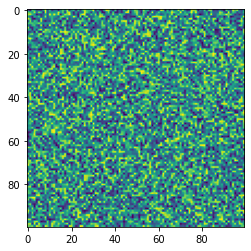

In [7]:
cluster.scale(10) # starts ten of the clusters described in the cell above
plt.imshow(x)
cluster.scale(0) # closes them

Or tell dask to manage the resources by itself:

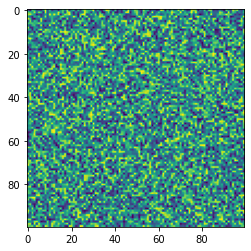

In [8]:
cluster.adapt()
plt.imshow(x)